# **Sentiment Analysis of IMDB Dataset using LLAMA-3.2-1B**


Install the necessary Python packages as outlined below:


In [ ]:

!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 5.8 MB/s eta 0:00:00
   

Next, we need to import all the necessary Python packages and functions.


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

Load Dataset

hf_link = https://huggingface.co/datasets/stanfordnlp/imdb

In [ ]:
import pandas as pd

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Display the count for each label
print(label_counts)


label
0    12500
1    12500
Name: count, dtype: int64


In [ ]:
# Filter the DataFrame for each label
label_0 = df[df['label'] == 0].sample(n=1500, random_state=42)
label_1 = df[df['label'] == 1].sample(n=1500, random_state=42)

# Concatenate the two DataFrames
df = pd.concat([label_0, label_1])

# Shuffle the resulting DataFrame (optional)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows
df.head()


,text,label
0,This is a deliriously colossal vulgar silly al...,1
1,Let me start off by saying that I didn't watch...,0
2,I very much enjoyed watching this film. I tape...,1
3,Extremely thin 'plot' of satanic rituals or so...,0
4,Who knew they could be so funny?? Christopher ...,1


In [ ]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Display the count for each label
print(label_counts)

label
1    1500
0    1500
Name: count, dtype: int64


Map the labels to "NegativePositive" and "spam"

In [ ]:
# Map the labels to "ham" and "spam"
df['map_label'] = df['label'].map({0: 'Negative', 1: 'Positive'})

# Display the first few rows to verify the changes
df.head()


,text,label,map_label
0,This is a deliriously colossal vulgar silly al...,1,Positive
1,Let me start off by saying that I didn't watch...,0,Negative
2,I very much enjoyed watching this film. I tape...,1,Positive
3,Extremely thin 'plot' of satanic rituals or so...,0,Negative
4,Who knew they could be so funny?? Christopher ...,1,Positive


We will then split the dataset into the train, eval, and test sets for model training and testing.

We also want to create the “text” column in train and eval sets using the generate_prompt function, which combines the data from the *“sms”* and *“map_label”* columns.

Finally, we’ll create the *“text”* column in the test set using the generate_test_prompt function and the y_true using the “map_label” column. We will use it to generate the model evaluation report, as shown below.

At this point, we want to check the distribution of categories in the train set.

In [ ]:
# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Calculate sizes
train_end = int(train_size * len(df))
eval_end = train_end + int(eval_size * len(df))

# Split the data
X_train = df[:train_end]
X_eval = df[train_end:eval_end]
X_test = df[eval_end:]

print(len(X_train))
print(len(X_eval))
print(len(X_test))

2400
300
300


In [ ]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into negative and positive, and return the answer as the corresponding text label.
text: {data_point["text"]}
label: {data_point["map_label"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into negative and positive, and return the answer as the corresponding text label.
text: {data_point["text"]}
label: """.strip()

# Generate prompts for training and evaluation data
X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)

# Generate test prompts and extract true labels
y_true = X_test.loc[:,'map_label']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])


In [21]:
X_train.map_label.value_counts()

,count
map_label,
Negative,1205
Positive,1195


So, next, we want to convert the train and eval set into the Hugging Face datasets.

In [ ]:
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
eval_data = Dataset.from_pandas(X_eval[["text"]])

In [ ]:
train_data['text'][5]

"Classify the text into negative and positive, and return the answer as the corresponding text label.\ntext: I see where a few people involved in this debacle wrote reviews to share their side of the story, and I thought what they wrote was helpful in understanding it. The fact that they basically came up with excuses -- rewrites, budget constraints, production formats etc -- simply underlines how bad this movie is. And my criticisms in panning it are not personally directed but simply a warning that this one doesn't make the cut.<br /><br />It's watchable, but barely so. There are plot holes in every corner, the dialogue borders on the ridiculous, and the ending is telegraphed a mile away. The modestly interesting feature of a hologram interacting with a recon team get drowned in silly dialogue like who makes a meal in the midst of what is supposed to be a tense and deadly encounter with an unknown enemy. Would ya wrassle us up some Hamburger Helper Sally, between us getting killed by

In [ ]:
print("Ttrain Columns:", X_train.columns)
print("eval Columns:", X_eval.columns)
print("Test Columns:", X_test.columns)


Ttrain Columns: Index(['text', 'label', 'map_label'], dtype='object')
eval Columns: Index(['text', 'label', 'map_label'], dtype='object')
Test Columns: Index(['text'], dtype='object')


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

# Loading the model and tokenizer

Next, we want to load the Llama-3.2-1b-instruct model in 4-bit quantization to save the GPU memory.

We will then load the tokenizer and set the pad token id.

In [ ]:
base_model_name = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

# Model evaluation before fine-tuning

Here, we create the predict function, which will use the text generation pipeline to predict labels from the “text” column. Running the function will return a list of sms spam categories based on various samples in the testing set.

In [ ]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["Negative", "Positive"]

    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=5,  # try a higher value here if needed
            temperature=0.1
        )

        result = pipe(prompt)
        # print("Generated text:", result[0]['generated_text'])  # Add print statement here

        answer = result[0]['generated_text'].split("label:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

y_pred = predict(X_test, model, tokenizer)


100%|██████████| 300/300 [01:18<00:00,  3.80it/s]


After, we create the evaluate function that will use the predicted labels and true labels to calculate the overall accuracy of the model and the accuracy per category, generate a classification report, and print out a confusion matrix. Running the function will give us a detailed model evaluation summary.

In [ ]:
def evaluate(y_true, y_pred):
    labels = ["Negative", "Positive"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

evaluate(y_true, y_pred)

Accuracy: 0.693
Accuracy for label Negative: 0.833
Accuracy for label Positive: 0.574

Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.83      0.71       138
    Positive       0.80      0.57      0.67       162

    accuracy                           0.69       300
   macro avg       0.71      0.70      0.69       300
weighted avg       0.72      0.69      0.69       300


Confusion Matrix:
[[115  23]
 [ 69  93]]


# Building the model

When building the model, we start by extracting the linear module names from the model using the bits and bytes library.

We then configure LoRA using the target modules, task type, and other arguments before setting up training arguments.

We will then create the model trainer using training arguments, a model, a tokenizer, a LoRA configuration, and a dataset.

In [ ]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
modules = find_all_linear_names(model)
modules

['down_proj', 'v_proj', 'gate_proj', 'o_proj', 'q_proj', 'k_proj', 'up_proj']

In [24]:
output_dir = "llama-3.2-fine-tuned-model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=3,                      # number of training epochs
    per_device_train_batch_size=4,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-4,                       # learning rate based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    eval_strategy="epoch",                    # evaluate at the end of each epoch
    save_strategy="epoch",                    # save a checkpoint at each epoch
    report_to="none"                          # disable wandb reporting
)


trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=512,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:334: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pas

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

# Model training

In [25]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,2.882400,2.910864
2,2.780000,2.892812
3,2.765400,2.892619


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=225, training_loss=2.886136850780911, metrics={'train_runtime': 2343.2962, 'train_samples_per_second': 3.073, 'train_steps_per_second': 0.096, 'total_flos': 1.908471933468672e+16, 'train_loss': 2.886136850780911, 'epoch': 3.0})

We can then save both the model adapter and tokenizer locally. In the next section, we will use this to merge the adopter with the base model.

In [26]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.2-fine-tuned-model/tokenizer_config.json',
 'llama-3.2-fine-tuned-model/special_tokens_map.json',
 'llama-3.2-fine-tuned-model/tokenizer.json')

# **Testing model after fine-tuning**

Now comes the most crucial part. Will our model perform better after fine-tuning it, or will it get worse? To find out, we must run the 'predict' function on the test set and then the 'evaluate' function to generate a model evaluation report.

In [27]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 300/300 [02:07<00:00,  2.36it/s]

Accuracy: 0.957
Accuracy for label Negative: 0.971
Accuracy for label Positive: 0.944

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.95       138
    Positive       0.97      0.94      0.96       162

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300


Confusion Matrix:
[[134   4]
 [  9 153]]


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_true and y_pred are your true and predicted labels
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision for the positive class (1)
precision = precision_score(y_true, y_pred, pos_label= "Positive")

# Calculate recall for the positive class (1)
recall = recall_score(y_true, y_pred, pos_label="Positive")

# Calculate F1 score for the positive class (1)
f1 = f1_score(y_true, y_pred, pos_label="Positive")

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9567
Precision: 0.9745
Recall: 0.9444
F1 Score: 0.9592


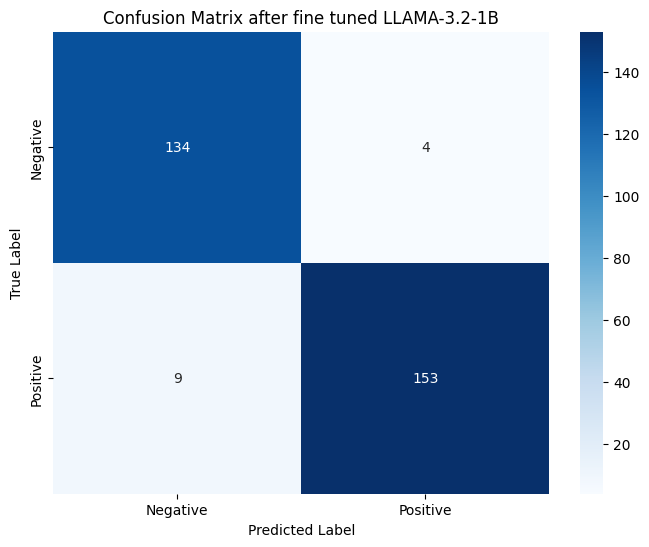

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Negative', 'Positive'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix after fine tuned LLAMA-3.2-1B')
plt.show()


We can now save the model and tokenizer locally.

In [34]:
model_dir = "Llama-3.2-1B-Movie-Sentiment-Analysis"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('Llama-3.2-1B-Movie-Sentiment-Analysis/tokenizer_config.json',
 'Llama-3.2-1B-Movie-Sentiment-Analysis/special_tokens_map.json',
 'Llama-3.2-1B-Movie-Sentiment-Analysis/tokenizer.json')

And then push the model and tokenizer to the Hugging Face Hub.

In [35]:
model.push_to_hub(model_dir, use_temp_dir=False)
tokenizer.push_to_hub(model_dir, use_temp_dir=False)

model.safetensors:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ali-jaan/Llama-3.2-1B-Movie-Sentiment-Analysis/commit/ad07a62c81a5f39012745990fc840f3750b6d574', commit_message='Upload tokenizer', commit_description='', oid='ad07a62c81a5f39012745990fc840f3750b6d574', pr_url=None, pr_revision=None, pr_num=None)

This will create the repository on Hugging Face and push all the model and tokenizer files.




In [37]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."

In [39]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="ali-jaan/Llama-3.2-1B-Movie-Sentiment-Analysis")
classifier(text)

config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ali-jaan/Llama-3.2-1B-Movie-Sentiment-Analysis and are newly initialized: ['model.layers.0.mlp.down_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.10.mlp.down_proj.weight', 'model.layers.10.mlp.gate_proj.weight', 'model.layers.10.mlp.up_proj.weight', 'model.layers.10.self_attn.k_proj.weight', 'model.layers.10.self_attn.o_proj.weight', 'model.layers.10.self_attn.q_proj.weight', 'model.layers.1

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.8989219069480896}]

In [40]:
# Use a pipeline as a high-level helper
from transformers import pipeline

messages = [
    {"This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."},
]
pipe = pipeline("sentiment-analysis", model="ali-jaan/Llama-3.2-1B-Movie-Sentiment-Analysis")
pipe(messages)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at ali-jaan/Llama-3.2-1B-Movie-Sentiment-Analysis and are newly initialized: ['model.layers.0.mlp.down_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.10.mlp.

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).